In [19]:
!pip install -q holidays
!pip install -q sktime
!pip install -q seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import holidays

# Define the Encoder
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(EncoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    
    def forward(self, x):
        # Initialize hidden and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Pass input through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0))
        
        # hn and cn will be passed to the decoder
        return output, hn, cn


class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers):
        super(DecoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer to output real values
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden, cell):
        # Pass input through the LSTM
        output, (hn, cn) = self.lstm(x, (hidden, cell))
        
        # Pass through the fully connected layer to get real-valued predictions
        output = self.fc(output)
        return output, hn, cn


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        target_dim = target.size(2)
        
        # Tensor to store decoder outputs (real-valued)
        outputs = torch.zeros(batch_size, target_len - 1, target_dim).to(self.device)
        
        # Encode the source sequence
        encoder_output, hidden, cell = self.encoder(source)
        
        # First input to the decoder is the first time step of the target (to not rely on Autoregression during training)
        decoder_input = target[:, 0, :].unsqueeze(1)  # (batch_size, 1, output_dim)
        
        for t in range(0, target_len - 1):
            # Pass through the decoder
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            
            # Store the output (real-valued prediction)
            outputs[:, t, :] = output.squeeze(1)
            
            # Decide whether to use teacher forcing (Using True Last Value as input or Own Prediction)
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            decoder_input = target[:, t, :].unsqueeze(1) if teacher_force else output
        
        return outputs


def combined_loss(y_true_load, y_pred_load, y_true_outlier, alpha: float = 10.):
    mse_loss = nn.MSELoss()(y_pred_load, y_true_load)
    outlier_mse_loss = nn.MSELoss()(y_pred_load * y_true_outlier, y_true_load * y_true_outlier)
    
    total_loss = mse_loss + alpha * outlier_mse_loss
    return total_loss

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [72]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import SlidingWindowSplitter
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
import json
from tqdm.auto import tqdm

def augment(train_data: pd.DataFrame, target_column) -> pd.DataFrame:
    """Augment the training data with additional features."""


    train_data.loc[:, "dow"] = train_data[time_column].dt.dayofweek
    train_data.loc[:, "hour"] = train_data[time_column].dt.hour
    # get all holidays in the timeframe of the dataset
    holys = set(holidays.DE(years=list(range(train_data[time_column].dt.date.min().year, train_data[time_column].dt.date.max().year))).keys())
    train_data.loc[:, "is_holiday"] = train_data[time_column].dt.date.isin(holys).astype(int)

    return train_data

def preprocess(train_data, test_data, target_column):
    """Data cleaning and normalization"""
    train_data.loc[:, target_column] = train_data.loc[:, target_column].interpolate()
    train_data = train_data.dropna(subset=[target_column])

    # Standardize
    mean = train_data.loc[:, target_column].mean()
    std = train_data.loc[:, target_column].std()
    train_data.loc[:, target_column] = (train_data.loc[:, target_column] - mean) / std
    test_data.loc[:, target_column] = (test_data.loc[:, target_column] - mean) / std
    
    return augment(train_data, target_column=target_column), test_data


target_column = "Price (EUR/MWhe)"
time_column = "Datetime (Local)"
df = pd.read_csv("data/european_wholesale_electricity_price_data_hourly/european_wholesale_electricity_price_data_hourly/Germany.csv")
df = df.sort_values(by="Datetime (UTC)")
df[time_column] = pd.to_datetime(df[time_column])
test_data = df[-24:]  # The last day is test data (for visualization only real test set should be much larger)
train_data = df[:-24]
train_data, test_data = preprocess(train_data, test_data, target_column)


# Set up splitter for 24h Forecast
splitter = SlidingWindowSplitter(fh=list(range(24)), window_length=100, step_length=8) 

X_train_windows = []
y_train_windows = []

X_data = train_data[[target_column, "dow", "hour", "is_holiday"]].values
y_data = train_data[[target_column]].values

for X_idx, y_idx in tqdm(splitter.split(train_data[target_column])):
    X_train, y_train = X_data[X_idx], y_data[y_idx]

    X_train_windows.append(X_train)
    y_train_windows.append(y_train)

X_train_tensor = torch.tensor(X_train_windows, dtype=torch.float32, requires_grad=True)
y_train_tensor = torch.tensor(y_train_windows, dtype=torch.float32, requires_grad=True)

dataset = TensorDataset(X_train_tensor, y_train_tensor)

0it [00:00, ?it/s]

In [75]:
def train(model: nn.Module, epochs: int, lr: float, batch_size: int, loss_fn: nn.Module, train_dataset: TensorDataset, val_dataset: TensorDataset, device="cpu"):
    """Fit the internal model(s)"""
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Set up Simple Early Stopping
    best_model_state_dict = None
    best_loss = np.inf

    training_process = []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = []
        for i, (x_window, y_window) in tqdm(enumerate(train_loader)):
            # Move data to CPU/GPU
            x_window = x_window.to(device)
            y_window = y_window.to(device)


            optimizer.zero_grad()
            # Make Prediction
            y_pred_window = model(x_window, y_window)
            # Calculate Loss
            loss = loss_fn(
                input=y_pred_window,
                target=y_window[:, 1:, :],
            )
            # Apply Gradient Descent Step
            loss.backward()
            optimizer.step()
            # Track Losses
            train_loss += [loss.item()]
        train_loss = np.mean(train_loss)

        # Check how good Model so far
        model.eval() # Set Model to Eval to avoid training on Validation Data 
        val_loss = []
        with torch.no_grad():
            for x_window, y_window in train_loader:
                x_window = x_window.to(device)
                y_window = y_window.to(device)

                y_pred_window = model(x_window, y_window, teacher_forcing_ratio=0.)
                loss = loss_fn(
                    input=y_pred_window,
                    target=y_window[:, 1:, :],
                )
                val_loss += [loss.item()]
        val_loss = np.mean(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state_dict = model.state_dict()

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
        training_process +=[{
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss
        }]

        assert best_model_state_dict is not None
        model.load_state_dict(best_model_state_dict)

    pd.DataFrame(training_process).to_csv(f"training_process.csv", index=False)
            
def predict(self, time_index: pd.Index) -> np.ndarray:
    """Predict the next value(s)"""
    t_0 = time_index[0]

    train_data = self.dataset.loc[self.dataset["Time stamp"].dt < t_0, :]
    train_data = train_data.iloc[-self.lookback, :]
    x_window = train_data.loc[:, ["target_normalized", "dow", "hour", "is_peak", "is_holiday"]].values
    
    x_window = torch.tensor(x_window).to(self.device).unsqueeze(0)

    # dummy
    y_window_load = torch.zeros(1, self.forecast_horizon, 1).to(self.device)

    y_pred_window = self.model(x_window, y_window_load, teacher_forcing_ratio=0.)

    y_pred_window = y_pred_window.cpu().numpy()
    
    return y_pred_window

In [76]:
input_dim = 4
output_dim = 1  # For example, size of the output features (same as input for many-to-many)
hidden_dim = 64  # LSTM hidden dimension
num_layers = 2  # Number of LSTM layers
learning_rate = 0.001
epochs = 10
batch_size=512

encoder = EncoderLSTM(input_dim, hidden_dim, num_layers).to(device)
decoder = DecoderLSTM(output_dim, hidden_dim, num_layers).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

train(
    model=model,
    epochs=epochs,
    lr=learning_rate,
    batch_size=batch_size,
    loss_fn=nn.MSELoss(),
    train_dataset=dataset,
    val_dataset=dataset,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1 - Train Loss: 0.88, Val Loss: 0.58


0it [00:00, ?it/s]

Epoch 2 - Train Loss: 0.33, Val Loss: 0.34


0it [00:00, ?it/s]

Epoch 3 - Train Loss: 0.23, Val Loss: 0.25


0it [00:00, ?it/s]

Epoch 4 - Train Loss: 0.19, Val Loss: 0.22


0it [00:00, ?it/s]

Epoch 5 - Train Loss: 0.18, Val Loss: 0.21


0it [00:00, ?it/s]

Epoch 6 - Train Loss: 0.17, Val Loss: 0.20


0it [00:00, ?it/s]

Epoch 7 - Train Loss: 0.17, Val Loss: 0.20


0it [00:00, ?it/s]

Epoch 8 - Train Loss: 0.16, Val Loss: 0.20


0it [00:00, ?it/s]

Epoch 9 - Train Loss: 0.16, Val Loss: 0.20


0it [00:00, ?it/s]

Epoch 10 - Train Loss: 0.16, Val Loss: 0.20


<Axes: xlabel='epoch', ylabel='train_loss'>

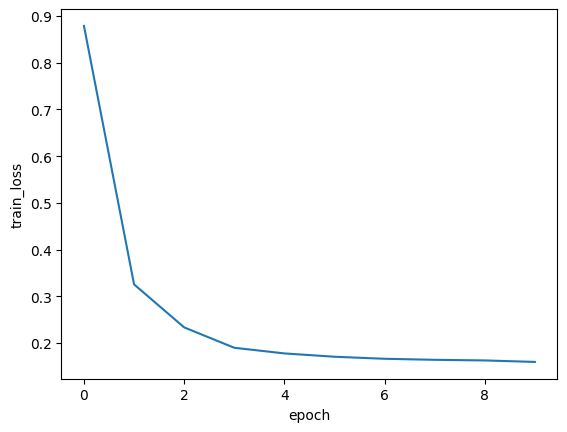

In [77]:
import seaborn as sns
training_process = pd.read_csv("training_process.csv")

sns.lineplot(data=training_process, x="epoch", y="train_loss")

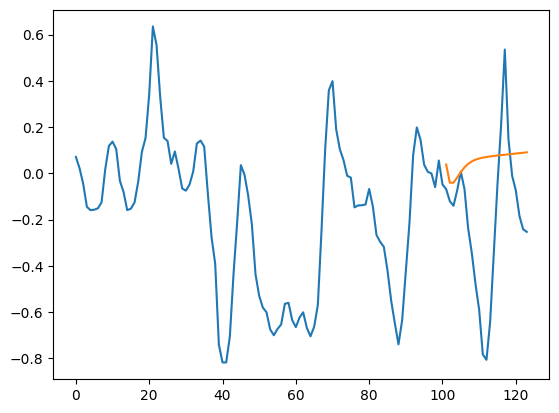

In [106]:
import matplotlib.pyplot as plt
# The Last 100 Datapoints 
input_for_forecast = torch.tensor(X_data[-100:], dtype=torch.float32, requires_grad=False)
# Batch size of one & Move to GPU/CPU
input_for_forecast = input_for_forecast.unsqueeze(dim=0).to(device)
placeholder = torch.zeros(y_train_tensor[0].shape).unsqueeze(0).to(device)

prediction = model(input_for_forecast, placeholder, teacher_forcing_ratio=0.0)
# Concatenate input and expected output for Plotting
real_data = np.concatenate([train_data[target_column].iloc[-100:], test_data[target_column]])
plt.plot(range(len(real_data)), real_data)
plt.plot(range(101, len(real_data)), prediction.to("cpu").detach()[0,:,0].numpy())

# LSTMs often Struggle with Regression 
- When used Auto-Regressively (Last Output of Model becomes input for next prediction of model)
- Then it will predict after a certain number of steps just the mean value of the time series
- One can see above that for the first 6 or so hours the forecast is relatively exact but becomes much worse over time
- Common Approaches to address this is to avoid Auto-Regressive Modeling all together, meaning:
    - Training several LSTM one Trained to predict the next hour, another tries to predict the hour after that and so on -> 24 models are required to predict the next 24 hours
    - Training an LSTM that returns a vector meaning the next 24 values are put into a vector of length 24 

In [102]:
prediction = model(input_for_forecast, placeholder, teacher_forcing_ratio=0.0)
# Concatenate input and expected output for Plotting
real_data = np.concatenate([train_data[target_column].iloc[-100:], test_data[target_column]])
plt.plot(range(len(real_data)), real_data)
plt.plot(range(101, len(real_data)), prediction.to("cpu").detach()[0,:,0].numpy())

tensor([ 0.0381, -0.0405, -0.0404, -0.0185,  0.0056,  0.0258,  0.0409,  0.0516,
         0.0590,  0.0642,  0.0680,  0.0708,  0.0731,  0.0752,  0.0770,  0.0787,
         0.0804,  0.0821,  0.0838,  0.0855,  0.0872,  0.0890,  0.0907],
       grad_fn=<SqueezeBackward0>)

In [93]:
np.concatenate([train_data[target_column].iloc[-100:], test_data[target_column]]).shape

(124,)

In [63]:
test.loc[:, target_column] = (test.loc[:, target_column] - train_data.loc[:, target_column].mean()) / train_data.loc[:, target_column].std()
test

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
81048,Germany,DEU,2024-03-31 00:00:00,2024-03-31 01:00:00,66.71
81049,Germany,DEU,2024-03-31 01:00:00,2024-03-31 03:00:00,64.98
81050,Germany,DEU,2024-03-31 02:00:00,2024-03-31 04:00:00,60.48
81051,Germany,DEU,2024-03-31 03:00:00,2024-03-31 05:00:00,58.74
81052,Germany,DEU,2024-03-31 04:00:00,2024-03-31 06:00:00,64.46
81053,Germany,DEU,2024-03-31 05:00:00,2024-03-31 07:00:00,71.51
81054,Germany,DEU,2024-03-31 06:00:00,2024-03-31 08:00:00,65.03
81055,Germany,DEU,2024-03-31 07:00:00,2024-03-31 09:00:00,50.32
81056,Germany,DEU,2024-03-31 08:00:00,2024-03-31 10:00:00,41.03
81057,Germany,DEU,2024-03-31 09:00:00,2024-03-31 11:00:00,29.52


In [64]:
(test.loc[:, target_column] - train_data.loc[:, target_column].mean()) / train_data.loc[:, target_column].std()

81048     66.71
81049     64.98
81050     60.48
81051     58.74
81052     64.46
81053     71.51
81054     65.03
81055     50.32
81056     41.03
81057     29.52
81058     19.85
81059      3.06
81060      1.03
81061     15.27
81062     41.07
81063     66.74
81064     89.32
81065    117.29
81066     83.72
81067     70.00
81068     64.51
81069     54.90
81070     49.95
81071     48.98
Name: Price (EUR/MWhe), dtype: float64

In [91]:
test_data[target_column]

81048   -0.048551
81049   -0.068531
81050   -0.120501
81051   -0.140595
81052   -0.074536
81053    0.006883
81054   -0.067953
81055   -0.237836
81056   -0.345125
81057   -0.478051
81058   -0.589728
81059   -0.783633
81060   -0.807077
81061   -0.642622
81062   -0.344663
81063   -0.048205
81064    0.212567
81065    0.535587
81066    0.147894
81067   -0.010556
81068   -0.073959
81069   -0.184943
81070   -0.242109
81071   -0.253312
Name: Price (EUR/MWhe), dtype: float64